In [5]:
#!/usr/bin/env python
# coding: utf-8

# # This will be the file that is converted to a .py and deployed to server


print("importing...")
import math
import os
import sys
from itertools import chain

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from skimage.io import imread
from skimage.transform import resize
from flask import Flask, request, jsonify
import json


print(sys.executable)
print(sys.version)
print(os.getcwd())

MODEL_SEMVER = '0.2.0'
IS_TEST_RUN = False # gross, I know

importing...
C:\Users\tjvan\Documents\local_programs\miniconda3\envs\pyds\python.exe
3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
C:\Users\tjvan\Documents\projects_for_learning\01_pynumdraw\pynumdraw\back_end


In [2]:
def reshape_and_resize_image(p_image_data):
    
    """
    expect a one-dimensional list of pixel values that make up a single-channel 300x300 pixel image.
    The pixels are in row-wise order. 
    
    #expected_pixel_width = 300
    #expected_pixel_height = 300
    #model_required_pixel_width = 28
    #model_required_pixel_height = 28
    """
    
    
    # determine new shape (28x28 if executing back-end test; 300x300 if coming from front-end)
    print("len(p_image_data) in reshape_and_resize_image function", len(p_image_data))
    
    width_and_height = int(math.sqrt(len(p_image_data)))
    print(f"dimensions of front end canvas must be {width_and_height} by {width_and_height}")
    
    if len(p_image_data) == (28 * 28):
        print("yes")
        # convert to new shape
        x = np.asarray(p_image_data)
        x = x.reshape((1, 28, 28, 1))
    
    elif len(p_image_data) == (width_and_height * width_and_height):
        print("no")
        # resize and convert to new shape
        x = np.asarray(p_image_data)
        x = x.reshape((width_and_height, width_and_height))
        x = resize(x, output_shape=(28, 28, 1))
        x = x.reshape((1, 28, 28, 1))
    else:
        raise("Error: Looks like front-end sent us a non-square canvas...")
    
    print("shape of prediction after `reshape_and_resize_image()` function:", x.shape)
    return x


def flatten_ndarray_to_1d_list(p_ndarray):
    """
    given ndarray of dimensions (width, height, channel), flatten those dimensions into
    a single dimension list. This is mostly a helper function to create sample test
    data that closely mimics what we would receive from the javascript front-end AJAX
    call after the user has drawn their number.
    """
    x = list(chain.from_iterable(p_ndarray.tolist()))
    print("length of returned list from flatten_ndarray_to_1d_list:", len(x))
    return x


def predict_on_new_data(p_newdata, p_model, p_model_version, p_label=None):
    """
    p_newdata (1d flat list of row-wise datapoints with length of 28 * 28)
    
    returns a dict with keys:
    - predicted_number (int): the number the model predicts was drawn on the canvas
    - confidence (str): how confident the model is about the prediction
    - model_version (str): the semantic version of the model used for the prediction
    """
    
    # set up class labels
    # class_labels = [str(x) for x in range(0, 10)]
    
    # preprocess and generate prediction class probabilities
    p_newdata = reshape_and_resize_image(p_newdata)
    predicted_probabilities = p_model.predict(p_newdata)
    
    # collect results
    results = {} 
    results["predicted_number"] = int(np.argmax(predicted_probabilities))
    results["confidence"] =  str(int(100 * np.max(predicted_probabilities)))
    results["model_version"] = str(p_model_version)
    if p_label:
        results["label"] = p_label
    
    return results
    
    
    

In [3]:


# load model immediately
print("loading tensorflow model weights...")
model = keras.models.load_model(filepath=f"pynumdraw_model_{MODEL_SEMVER}.hdf5", compile=False)


app = Flask(__name__)


@app.route('/predict_number/', methods=['POST'])
def predict_number():
    print("in predict_number function now")
    data = request.json
    results = predict_on_new_data(data['new_data'], model, MODEL_SEMVER)
    
    return jsonify(results)

@app.route("/hello/")
def hello():
    print("in hello function now")
    return "hello_world"







loading tensorflow model weights...


length of returned list from flatten_ndarray_to_1d_list: 784
len(p_image_data) in reshape_and_resize_image function 784
yes
shape of prediction after `reshape_and_resize_image()` function: (1, 28, 28, 1)
{'predicted_number': 9, 'confidence': '100', 'model_version': '0.2.0', 'label': 9}


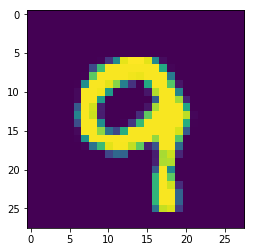

In [8]:
if IS_TEST_RUN:
    
    def read_mnist_image_data(image_data_file):
        """
        image_data_file: path to the mnist image data file on disk.

        returns a dictionary with the following keys:
        - magic_number: to be compared against the magic number for each file on MNIST website
        - number_of_images: the number of images included in the dataset
        - pixel_rows: the number of pixels per row per image
        - pixel_cols: the number of pixels per column per image
        - data: the actual image data as ndarray with shape of (number_of_images, pixel_rows, pixel_cols)
        """

        results = {}

        with open(image_data_file, 'rb') as f:
            _data = f.read()

        results['magic_number'] = int.from_bytes(_data[0:4], 'big')
        results['number_of_images'] = int.from_bytes(_data[4:8], 'big')
        results['pixel_rows'] = int.from_bytes(_data[8:12], 'big')
        results['pixel_cols'] = int.from_bytes(_data[12:16], 'big')

        pixel_data = np.asarray([pixel for pixel in _data[16:]])
        pixel_data = pixel_data.reshape(results['number_of_images'], results['pixel_rows'], results['pixel_cols'])
        results['data'] = pixel_data

        return results
    
    
    def read_mnist_label_data(label_data_file):
        """
        label_data_file: path to the mnist label data file on disk.

        returns a dictionary with the following keys:
        - magic_number: to be compared against the magic number for each file on MNIST website
        - number_of_labels: the number of labels included in the dataset
        - labels: the actual label data as ndarray (1 dimensional)
        """

        results = {}

        with open(label_data_file, 'rb') as f:
            _data = f.read()

        results['magic_number'] = int.from_bytes(_data[0:4], 'big')
        results['number_of_labels'] = int.from_bytes(_data[4:8], 'big')    
        results['labels'] = np.asarray([(label / 1.0) for label in _data[8:]]).astype('int')

        return results
    
    
    # TODO: replace this with a random sample within the test dataset
    test_indx = 99
    
    all_images = read_mnist_image_data("../data/t10k-images-idx3-ubyte")['data'] / 255.0
    all_labels = read_mnist_label_data("../data/t10k-labels-idx1-ubyte")['labels']
    
    test_image = all_images[test_indx, :, :]
    test_image = flatten_ndarray_to_1d_list(test_image)
    test_results = predict_on_new_data(test_image, model, MODEL_SEMVER, all_labels[test_indx])
    print(test_results)  
    
    
    from matplotlib.pyplot import imshow
    imshow(all_images[test_indx, :, :])
    

    
    
    

In [ ]:
# Dev (gross, I know)

# nvm, this doesn't really even work. If it was a small amount of JSON I had to 
# manually create in order to test the API, that'd be one thing. But this is a
# dense 300 x 300 pixel image that has to be tested on. So instead, we should
# take this testing offline.
# app.run(host='0.0.0.0', 8080)

In [ ]:
# Prod (gross, I know)
import bjoern

print("starting bjoern server now!")
bjoern.run(app, '127.0.0.1', 8080)